In [61]:
import pandas as pd
import csv
pd.set_option('display.max_columns', None)
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [48]:
import numpy as np
import random
import pprint
import pandas as pd
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
tf.disable_eager_execution()
import math
import matplotlib.pyplot as plt

In [37]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
df = pd.read_csv('bpi_2017_clean.csv')

### Removing Columns


In [16]:
df=df.drop(['Action','org:resource',
                'EventOrigin','EventID',
                'lifecycle:transition','case:LoanGoal',
                'case:ApplicationType','case:concept:name',
                'OfferID'],axis=1)

In [17]:
useful=['A_Cancelled','A_Pending','O_Create Offer','A_Denied']
data=df[df['concept:name'].isin(useful)].reset_index()


### Creating own dataframe


In [23]:
statlist=[]
for i in range(len(data)):
    if data['concept:name'][i]=='O_Create Offer':
        stats=[]
        stats.append(data['case:RequestedAmount'][i])
        stats.append(data['FirstWithdrawalAmount'][i])
        stats.append(data['NumberOfTerms'][i])
        stats.append(data['Accepted'][i])
        stats.append(data['MonthlyCost'][i])
        stats.append(data['Selected'][i])
        stats.append(data['CreditScore'][i])
        stats.append(data['OfferedAmount'][i])
    elif data['concept:name'][i]=='A_Pending':
        stats.append(1)
        statlist.append(stats)
    elif data['concept:name'][i]=='A_Denied':
        stats.append(-1)
        statlist.append(stats)
    else:
        stats.append(0)
        statlist.append(stats)


In [29]:
stats

[20000.0, '20000.0', '77.0', 'False', '297.81', 'False', '0.0', '20000.0', 0]

### Converting statlist into df

In [26]:
statlist=pd.DataFrame(statlist,columns=['RequestedAmount',
                                        'FirstWithdrawalAmount',
                                        'NumberOfTerms','Accepted',
                                        'MonthlyCost','Selected',
                                        'CreditScore','OfferedAmount',
                                        'Labels','NULL'])
statlist=statlist.drop(['NULL'],axis=1)

In [31]:
statlist['Labels'].unique()

array([ 1, -1,  0])

### Label Encoding

In [38]:
label = LabelEncoder()
statlist['Accepted']=label.fit_transform(statlist['Accepted'])
statlist['Selected']=label.fit_transform(statlist['Selected'])

In [39]:
dataX = (statlist[['RequestedAmount',
                   'FirstWithdrawalAmount',
                   'NumberOfTerms','Accepted',
                   'MonthlyCost','Selected',
                   'CreditScore','OfferedAmount']])
dataY = statlist[['Labels']]
dataX = np.asarray(dataX)
dataY = np.asarray(dataY)

### Training and Testing Split

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42)
X_train=X_train.T
X_test=X_test.T
Y_train=Y_train.T
Y_test=Y_test.T

In [45]:
X_train.shape, Y_train.shape

((8, 21046), (1, 21046))

### Building Model 

In [53]:
def create_placeholders(n_x, n_y):
    """
   
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    
    """

    
    X = tf.placeholder(tf.float32,[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,[n_y,None],name='Y')
    
    
    return X, Y

### Initialising Parameters

In [54]:
def initialize_parameters():
    
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    
    W1 = tf.get_variable('W1',[25,8],initializer=tf.glorot_uniform_initializer)
    b1 = tf.get_variable('b1',[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',[12,25],initializer=tf.glorot_uniform_initializer)
    b2 = tf.get_variable('b2',[12,1],initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3',[6,12],initializer=tf.glorot_uniform_initializer)
    b3 = tf.get_variable('b3',[6,1],initializer=tf.zeros_initializer())
   

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [55]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
               # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                              # Z3 = np.dot(W3, A2) + b3
    
    
    return Z3

In [56]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
   
    return cost

In [57]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [58]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0000001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True ):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    
    X, Y = create_placeholders(n_x, n_y)
    

    # Initialize parameters
    
    parameters = initialize_parameters()
    
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
   
    Z3 = forward_propagation(X, parameters)
   
    
    # Cost function: Add cost function to tensorflow graph
    
    cost = compute_cost(Z3, Y)
   
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost],{X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

       
        return parameters

### Implementation of the RNN

Cost after epoch 0: 305470.888031
Cost after epoch 100: 267913.026817
Cost after epoch 200: 235881.823639
Cost after epoch 300: 214210.630169
Cost after epoch 400: 197492.539375
Cost after epoch 500: 187968.345577
Cost after epoch 600: 180790.275766
Cost after epoch 700: 174781.632158
Cost after epoch 800: 170698.932140
Cost after epoch 900: 169056.667475


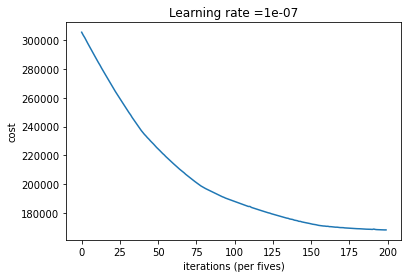

Parameters have been trained!
CPU times: user 9min 22s, sys: 1min 26s, total: 10min 49s
Wall time: 7min 48s


In [60]:
%%time

parameters = model(X_train, Y_train, X_test, Y_test)

### Loss function

In [72]:
dataX

array([[20000.0, '20000.0', '44.0', ..., 1, '979.0', '20000.0'],
       [10000.0, '500.0', '33.0', ..., 0, '0.0', '6000.0'],
       [15000.0, '15000.0', '120.0', ..., 1, '1059.0', '15000.0'],
       ...,
       [10000.0, '10000.0', '120.0', ..., 1, '854.0', '10000.0'],
       [30000.0, '0.0', '77.0', ..., 1, '996.0', '30000.0'],
       [20000.0, '20000.0', '77.0', ..., 0, '0.0', '20000.0']],
      dtype=object)

### Evaluation of Model

In [73]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy

In [77]:
%%time
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(dataX, dataY):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(dataX[train], dataY[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(dataX[test], dataY[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

/Users/jasbindrasingh/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


accuracy: 76.16%
accuracy: 76.51%
accuracy: 77.46%
accuracy: 76.73%
accuracy: 77.08%
accuracy: 78.03%
accuracy: 76.60%
accuracy: 77.11%
accuracy: 78.13%
accuracy: 76.95%
77.08% (+/- 0.61%)
CPU times: user 53min 25s, sys: 5min 30s, total: 58min 56s
Wall time: 46min 25s
